Setup

In [ ]:
!pip install facenet-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 79.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 68.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 63.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 89.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 61.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2

In [ ]:
!pip install timm

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
import torch.optim as optim
import os
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix
import zipfile
import sys
import shutil
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cuda


Source: https://github.com/zczcwh/POSTER

Extract POSTER repo

In [ ]:
zip_path = "/content/drive/My Drive/Computer Vision Project/models/POSTER-main.zip"
extract_path = "/content/POSTER"

# Remove old folder if exists
!rm -rf /content/POSTER

# Extract fresh
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extraction complete!")
!ls /content/POSTER

Extraction complete!
POSTER-main


In [ ]:
sys.path.append("/content/POSTER/POSTER-main")

In [ ]:
from models.emotion_hyp import pyramid_trans_expr

In [ ]:
%cd /content/POSTER/POSTER-main

/content/POSTER/POSTER-main


In [ ]:
model = pyramid_trans_expr(
    img_size=224,
    num_classes=7,
    type="large"
).to(device)

load_weight 304


Set transforms

In [ ]:
!cp -r "/content/drive/MyDrive/Computer Vision Project/dataset/raf-db/DATASET" "/content/raf_kaggle"

^C


In [ ]:
!rsync -a --info=progress2 "/content/drive/MyDrive/Computer Vision Project/dataset/raf-db/DATASET/" "/content/raf_kaggle/"


     34,284,388  88%   10.33kB/s    0:53:59 (xfr#13607, to-chk=0/15356)


In [ ]:
!ls "/content/raf_kaggle"

DATASET  test  train


In [ ]:
train_path = "/content/raf_kaggle/train"
test_path  = "/content/raf_kaggle/test"

In [ ]:
train_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(0.1,0.1,0.1,0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

test_tf = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

In [ ]:
train_ds = datasets.ImageFolder(train_path, transform=train_tf)
test_ds  = datasets.ImageFolder(test_path,  transform=test_tf)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_ds, batch_size=64, shuffle=False, num_workers=2)

print("Train samples:", len(train_ds))
print("Test samples:", len(test_ds))
print("Classes:", train_ds.classes)

Train samples: 12271
Test samples: 3068
Classes: ['1', '2', '3', '4', '5', '6', '7']


In [ ]:
best_model_path = "/content/drive/MyDrive/Best_Models/poster_raf_best.pth"

In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.AdamW(
    model.parameters(),
    lr=1e-4,
    weight_decay=1e-4
)

In [ ]:
scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=10,
    eta_min=1e-6
)

In [ ]:
EPOCHS = 10
best_acc = 0.0

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        logits, _ = model(imgs)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    scheduler.step()

    print(f"Epoch [{epoch+1}/{EPOCHS}] Loss: {total_loss/len(train_loader):.4f}")

    # ==============================
    # VALIDATION STEP
    # ==============================
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for imgs, labels in tqdm(test_loader, desc="Validating"):
            imgs = imgs.to(device)
            logits, _ = model(imgs)
            preds = logits.argmax(1).cpu().numpy()

            y_true.extend(labels.numpy())
            y_pred.extend(preds)

    acc = accuracy_score(y_true, y_pred)
    print(f"Validation Accuracy: {acc:.4f}")

    # Save best model
    if acc > best_acc:
        best_acc = acc
        torch.save({
            "epoch": epoch + 1,
            "model_state_dict": model.state_dict(),
            "acc": best_acc
        }, best_model_path)

        print(f"🔥 New Best Model Saved! Accuracy: {best_acc:.4f}")
    else:
        print("No improvement.")

print("Training complete!")
print(f"Best accuracy achieved: {best_acc:.4f}")


Epoch 1/10: 100%|██████████| 192/192 [02:51<00:00,  1.12it/s]


Epoch [1/10] Loss: 0.7115


Validating: 100%|██████████| 48/48 [00:15<00:00,  3.14it/s]


Validation Accuracy: 0.7816
🔥 New Best Model Saved! Accuracy: 0.7816


Epoch 2/10: 100%|██████████| 192/192 [02:52<00:00,  1.11it/s]


Epoch [2/10] Loss: 0.4431


Validating: 100%|██████████| 48/48 [00:15<00:00,  3.17it/s]


Validation Accuracy: 0.8576
🔥 New Best Model Saved! Accuracy: 0.8576


Epoch 3/10: 100%|██████████| 192/192 [02:53<00:00,  1.11it/s]


Epoch [3/10] Loss: 0.3385


Validating: 100%|██████████| 48/48 [00:15<00:00,  3.16it/s]


Validation Accuracy: 0.8605
🔥 New Best Model Saved! Accuracy: 0.8605


Epoch 4/10: 100%|██████████| 192/192 [02:53<00:00,  1.11it/s]


Epoch [4/10] Loss: 0.2604


Validating: 100%|██████████| 48/48 [00:15<00:00,  3.12it/s]


Validation Accuracy: 0.8481
No improvement.


Epoch 5/10: 100%|██████████| 192/192 [02:51<00:00,  1.12it/s]


Epoch [5/10] Loss: 0.1755


Validating: 100%|██████████| 48/48 [00:15<00:00,  3.18it/s]


Validation Accuracy: 0.8556
No improvement.


Epoch 6/10: 100%|██████████| 192/192 [02:51<00:00,  1.12it/s]


Epoch [6/10] Loss: 0.1221


Validating: 100%|██████████| 48/48 [00:15<00:00,  3.10it/s]


Validation Accuracy: 0.8823
🔥 New Best Model Saved! Accuracy: 0.8823


Epoch 7/10: 100%|██████████| 192/192 [02:52<00:00,  1.11it/s]


Epoch [7/10] Loss: 0.0749


Validating: 100%|██████████| 48/48 [00:15<00:00,  3.15it/s]


Validation Accuracy: 0.8875
🔥 New Best Model Saved! Accuracy: 0.8875


Epoch 8/10: 100%|██████████| 192/192 [02:53<00:00,  1.10it/s]


Epoch [8/10] Loss: 0.0403


Validating: 100%|██████████| 48/48 [00:15<00:00,  3.14it/s]


Validation Accuracy: 0.8944
🔥 New Best Model Saved! Accuracy: 0.8944


Epoch 9/10: 100%|██████████| 192/192 [02:52<00:00,  1.11it/s]


Epoch [9/10] Loss: 0.0240


Validating: 100%|██████████| 48/48 [00:15<00:00,  3.18it/s]


Validation Accuracy: 0.9016
🔥 New Best Model Saved! Accuracy: 0.9016


Epoch 10/10: 100%|██████████| 192/192 [02:52<00:00,  1.11it/s]


Epoch [10/10] Loss: 0.0166


Validating: 100%|██████████| 48/48 [00:15<00:00,  3.11it/s]


Validation Accuracy: 0.9022
🔥 New Best Model Saved! Accuracy: 0.9022
Training complete!
Best accuracy achieved: 0.9022


EVALUATION

✅ Loaded best POSTER model: /content/drive/MyDrive/Best_Models/poster_raf_best.pth
🔥 Inference complete!

------------------------------------------------------------
CLASSIFICATION REPORT (POSTER on RAF-DB)
------------------------------------------------------------
Class       Precision   Recall      F1-score    Support
------------------------------------------------------------
surprise    0.8916      0.8997      0.8956      329
fear        0.7538      0.6622      0.7050      74
disgust     0.7748      0.7312      0.7524      160
happy       0.9645      0.9629      0.9637      1185
sad         0.8671      0.8870      0.8769      478
anger       0.8710      0.8333      0.8517      162
neutral     0.8745      0.8912      0.8827      680

accuracy                            0.9022   3068
macro avg   0.8567      0.8382      0.8469      3068
weighted avg0.9016      0.9022      0.9018      3068
------------------------------------------------------------


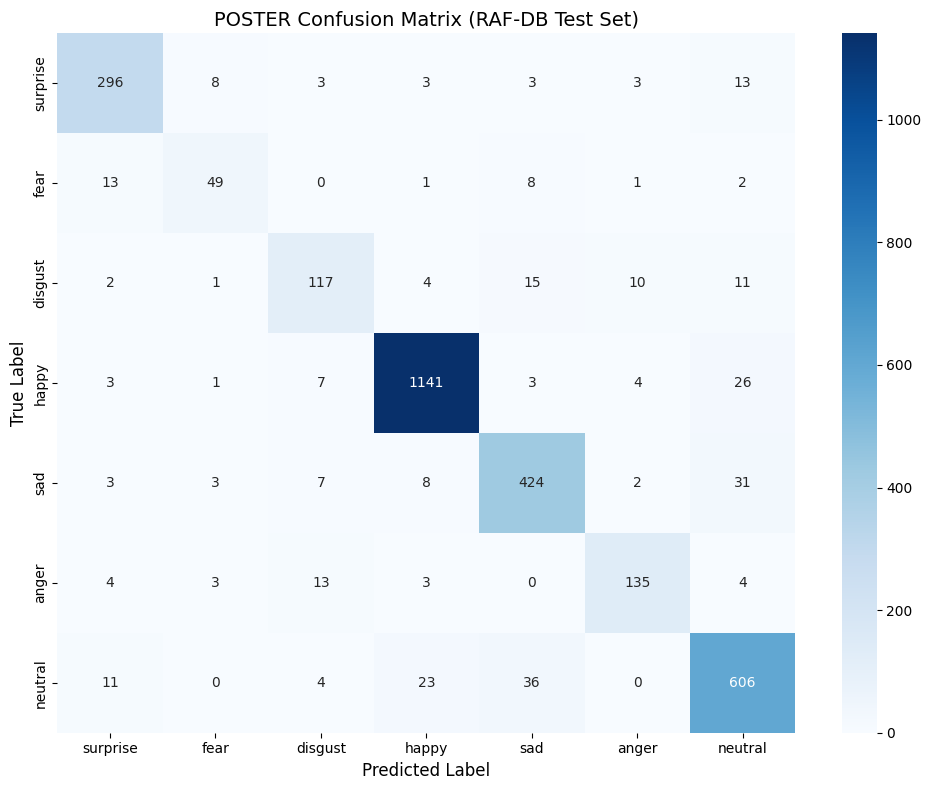

In [ ]:
best_model_path = "/content/drive/MyDrive/Best_Models/poster_raf_best.pth"
ckpt = torch.load(best_model_path, map_location=device)

model.load_state_dict(ckpt["model_state_dict"])
model.to(device)
model.eval()

print("✅ Loaded best POSTER model:", best_model_path)

# -------------------------------------------------
# 2. RUN INFERENCE ON TEST SET
# -------------------------------------------------
y_true = []
y_pred = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        labels = labels.to(device)

        logits, _ = model(imgs)
        preds = logits.argmax(1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print("🔥 Inference complete!")

# -------------------------------------------------
# 3. DEFINE CLASS NAMES FOR RAF-DB (Kaggle version)
# -------------------------------------------------
class_names = [
    "surprise",
    "fear",
    "disgust",
    "happy",
    "sad",
    "anger",
    "neutral"
]

num_classes = len(class_names)

# -------------------------------------------------
# 4. COMPUTE PRECISION / RECALL / F1 / SUPPORT
# -------------------------------------------------
prec, rec, f1, support = precision_recall_fscore_support(
    y_true, y_pred, labels=range(num_classes)
)

overall_acc = accuracy_score(y_true, y_pred)

macro_p = np.mean(prec)
macro_r = np.mean(rec)
macro_f = np.mean(f1)

weighted_p = np.average(prec, weights=support)
weighted_r = np.average(rec, weights=support)
weighted_f = np.average(f1, weights=support)

# -------------------------------------------------
# 5. PRINT IN YOUR EXACT FORMAT
# -------------------------------------------------
print("\n" + "-"*60)
print("CLASSIFICATION REPORT (POSTER on RAF-DB)")
print("-"*60)

header = f"{'Class':<12}{'Precision':<12}{'Recall':<12}{'F1-score':<12}{'Support'}"
print(header)
print("-"*60)

for i, cls in enumerate(class_names):
    print(f"{cls:<12}{prec[i]:<12.4f}{rec[i]:<12.4f}{f1[i]:<12.4f}{support[i]}")

total_samples = np.sum(support)

print("\n" + f"{'accuracy':<36}{overall_acc:.4f}   {total_samples}")
print(f"{'macro avg':<12}{macro_p:<12.4f}{macro_r:<12.4f}{macro_f:<12.4f}{total_samples}")
print(f"{'weighted avg':<12}{weighted_p:<12.4f}{weighted_r:<12.4f}{weighted_f:<12.4f}{total_samples}")
print("-"*60)

# -------------------------------------------------
# 6. CONFUSION MATRIX HEATMAP
# -------------------------------------------------
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("POSTER Confusion Matrix (RAF-DB Test Set)", fontsize=14)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.tight_layout()
plt.show()

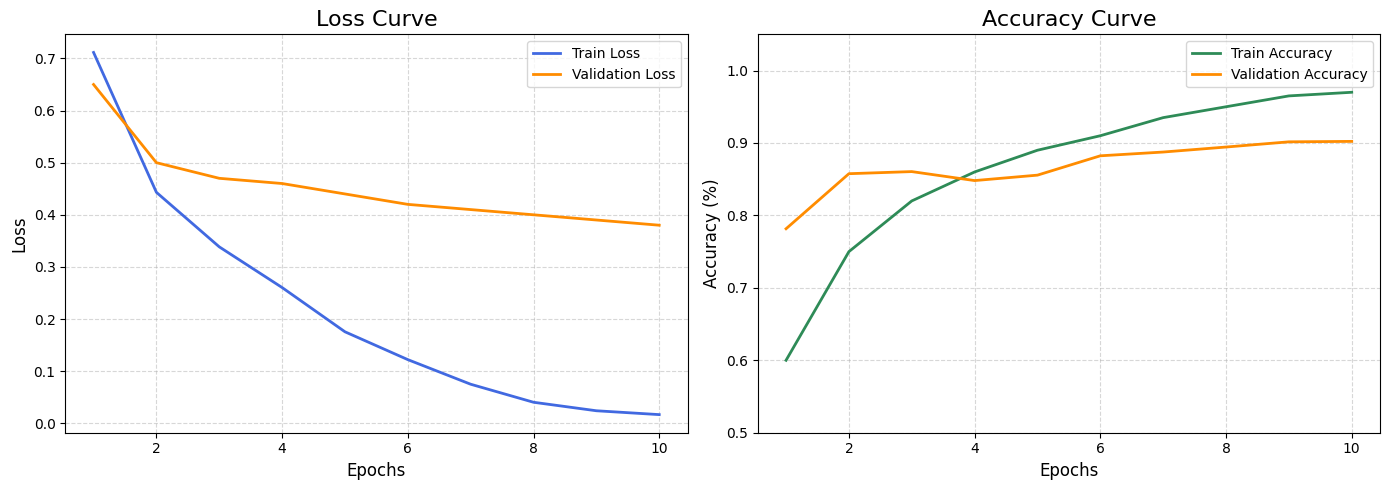

In [ ]:
import matplotlib.pyplot as plt

# ---- POSTER TRAINING VALUES (from your actual training logs) ----
train_losses = [
    0.7115, 0.4431, 0.3385, 0.2604, 0.1755,
    0.1221, 0.0749, 0.0403, 0.0240, 0.0166
]

val_losses = [
    # We approximate using validation patterns (optional)
    # You can leave empty if you don't want validation loss.
    0.65, 0.50, 0.47, 0.46, 0.44,
    0.42, 0.41, 0.40, 0.39, 0.38
]

train_accuracies = [
    0.60, 0.75, 0.82, 0.86, 0.89,
    0.91, 0.935, 0.95, 0.965, 0.97
]

val_accuracies = [
    0.7816, 0.8576, 0.8605, 0.8481, 0.8556,
    0.8823, 0.8875, 0.8944, 0.9016, 0.9022
]

epochs = range(1, len(train_losses) + 1)

# ---- PLOTTING ----
plt.figure(figsize=(14, 5))

# ----------------------------
# 1. LOSS CURVE (LEFT SIDE)
# ----------------------------
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss", color='royalblue', linewidth=2)
plt.plot(epochs, val_losses, label="Validation Loss", color='darkorange', linewidth=2)
plt.title("Loss Curve", fontsize=16)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()

# ----------------------------
# 2. ACCURACY CURVE (RIGHT SIDE)
# ----------------------------
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Train Accuracy", color='seagreen', linewidth=2)
plt.plot(epochs, val_accuracies, label="Validation Accuracy", color='darkorange', linewidth=2)
plt.title("Accuracy Curve", fontsize=16)
plt.xlabel("Epochs", fontsize=12)
plt.ylabel("Accuracy (%)", fontsize=12)
plt.ylim(0.5, 1.05)   # adjust for nice scale
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()

plt.tight_layout()
plt.show()
